In [120]:
from mne.datasets import multimodal
import mne
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
# for c in cond:
#     c['tmax'] = 1.2
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs.apply_baseline((None, 0))
epochs.crop(0, None)

Opening raw data file /home/user/mne_data/MNE-multimodal-data/multimodal_raw.fif...
    Read a total of 7 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 183600 ... 576599 =    305.687 ...   960.014 secs
Ready.
Not setting metadata
118 matching events found
Setting baseline interval to [-0.09989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 7)
7 projection items activated
Not setting metadata
129 matching events found
Setting baseline interval to [-0.09989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 7)
7 proje

Number of events,940
Events,Auditory left: 117Auditory right: 104Somato left: 118Somato right: 107Visual Lower left: 115Visual Lower right: 129Visual Upper left: 133Visual Upper right: 117
Time range,0.000 – 0.499 sec
Baseline,-0.100 – 0.000 sec


In [3]:
dataset = EpochsDataset(epochs, savepath='../trash', transform = zscore)

In [4]:
dataset.save('../data/dataset.pt')

In [5]:
del epochs

In [6]:
dataset = read_epochs_dataset('../data/dataset.pt')

In [7]:
class TinyNet(torch.nn.Module):

    def __init__(self, n_channels, n_latent, n_times, pool_factor, n_outputs):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=False)
        self.unmixing_layer_batchnorm = nn.BatchNorm1d(n_latent, affine=False)
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.features_batchnorm = nn.BatchNorm1d(final_out_features, affine=False)
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x):
        x = self.unmixing_layer(x)
        x = self.unmixing_layer_batchnorm(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        x = self.features_batchnorm(x)
        return self.fc_layer(x)

In [2]:
def plot_metrics(metrics):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [16]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = TinyNet(204, 8, 301, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)



In [ ]:

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
    ]
)
metrics = trainer.fit(train_loader, 25, val_loader)
plot_metrics(metrics)

In [13]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.4838923712571462
train_acc: 0.8077647884686788
loss: 0.5737608075141907
acc: 0.7134222388267517


In [15]:
type(optimizer)

torch.optim.adam.Adam

In [99]:
from typing import Callable, Sequence


class BaseModel(torch.nn.Module):
    """
    A base class for creating models with PyTorch.
    This class provides common functionalities such as training, evaluation, saving and loading.

    Attributes:
        trainer (Trainer): The trainer object used to train the model.
    """

    def __init__(self):
        """
        Initializes the BaseModel.
        """
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model. This function should be implemented by subclasses.

        Args:
            x (torch.Tensor): Input to the model.

        Returns:
            torch.Tensor: Output of the model.
        """
        ...

    @staticmethod
    def _prepare_dataloaders(
        data: Dataset | DataLoader,
        batch_size: int,
        val_data: Dataset | DataLoader,
        val_batch_size: int
    ):
        """
        Prepare train and validation data loaders

        Args:
            data (Dataset | DataLoader): Input data. Can be either a PyTorch Dataset or a DataLoader object
            batch_size (int): batch size for the training data
            val_data (Dataset | DataLoader): Input validation data. Can be either a PyTorch Dataset or a DataLoader object
            val_batch_size (int): batch size for the validation data

        Returns:
            Tuple[DataLoader, DataLoader]: Tuple containing train and validation DataLoader objects

        Raises:
            ValueError: If data is DataLoader object and batch_size is given
            ValueError: If val_data is DataLoader object and val_batch_size is given
            TypeError: If input data is not a Dataset or DataLoader
            TypeError: If input val_data is not a Dataset or DataLoader

        """
        val_loader = None
        if isinstance(data, (Dataset, torch.utils.data.dataset.Subset)):
            if batch_size is None:
                batch_size = len(data)//10

            if val_data is not None or val_batch_size is None:
                train_loader = DataLoader(data, batch_size, shuffle=True)
            else:
                train_loader, val_loader = make_train_and_val_loaders(data, batch_size, val_batch_size)
        elif isinstance(data, DataLoader):
            if batch_size is not None:
                raise ValueError('If you give a Dataloader, you can not set batch_size')

            if (val_data is None and val_batch_size is not None):
                raise ValueError('Can not split data into train and test sets from dataloader. Give dataset instead or do not use validation')
            else:
                train_loader = data
        else:
            raise TypeError(f'Wrong type for input data: {type(data)}. Input data must be either Dataset or DataLoader')

        if val_loader is None:
            if isinstance(val_data, (Dataset, torch.utils.data.dataset.Subset)):
                if val_batch_size is None:
                    val_batch_size = len(val_data)//10
                val_loader = DataLoader(val_data, val_batch_size, shuffle=True)
            elif isinstance(val_data, DataLoader):
                if val_batch_size is not None:
                    raise ValueError('If you give a Dataloader, you can not set batch_size')
                val_loader = val_data
            elif val_data is None and val_batch_size is None :
                val_loader = None
            else:
                raise TypeError(f'Wrong type for validation data: {type(data)}. Validation data must be either Dataset or DataLoader')

        return train_loader, val_loader

    @staticmethod
    def _validate_metrics(
        metrics: Callable[[torch.Tensor, torch.Tensor], torch.Tensor] |\
            list[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] |\
            tuple[str, Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] |\
            list[tuple[str, Callable[[torch.Tensor, torch.Tensor], torch.Tensor]]] = None
    ):
        """
        Validate the given metrics and return a list of tuples of name and function

        Parameters:
            metrics: A single function, a list of functions, a tuple of name and function, a list of tuples of name and function.
                The function should take in two arguments, `output` and `target` and return a single value.
                If None, returns None.

        Returns:
            A list of tuples of name and function
        """
        if isinstance(metrics, Callable):
            return [(metrics.__name__, metrics)]
        elif isinstance(metrics, Sequence):
            if isinstance(metrics[0], str) and isinstance(metrics[1], Callable):
                return [tuple(metrics)]
            else:
                all_metrics = list()
                for metric in metrics:
                    if isinstance(metric, Callable):
                        all_metrics.append((metric.__name__, metric))
                    elif isinstance(metric[0], str) and isinstance(metric[1], Callable):
                        all_metrics.append(tuple(metric))
                return all_metrics
        else:
            return None

    def compile(
        self,
        optimizer: torch.optim.Optimizer = None,
        loss: nn.Module = None,
        metrics: Callable[[torch.Tensor, torch.Tensor], torch.Tensor] |\
            list[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] |\
            tuple[str, Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] |\
            list[tuple[str, Callable[[torch.Tensor, torch.Tensor], torch.Tensor]]] = None,
        callbacks: Callback | list[Callback] = None,
        trainer: Trainer = None,
        device: torch.device = None,
    ):
        """Compile the model with optimizer, loss, metrics, callbacks and trainer.

        Args:
            optimizer (torch.optim.Optimizer, optional): The optimizer used to train the model. Defaults to None. If None, the ADAM optimizer is used.
            loss (nn.Module, optional): Loss function used to compute the loss. Defaults to None. If None, the L1 loss function is used.
            metrics (Callable[[torch.Tensor, torch.Tensor], torch.Tensor] |
                list[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] |
                tuple[str, Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] |
                list[tuple[str, Callable[[torch.Tensor, torch.Tensor], torch.Tensor]]], optional): Metrics used to evaluate the model's performance.
                Defaults to None.
            callbacks (Callback | list[Callback], optional): Callbacks to be called during training. Defaults to None.
                If None, only callback for printing training progress will be used
            trainer (Trainer, optional): The trainer class used to train the model. Defaults to None. If None, Trainer is used.
            device (torch.device, optional): Device on which to train the model. Defaults to None. If None and cuda is available, cuda is used. Otherwise, cpu is used.

        """
        if optimizer is None:
            optimizer =  torch.optim.Adam(self.parameters())
        elif isinstance(optimizer, Callable):
            optimizer = optimizer(self.parameters())

        if loss is None:
            loss = torch.nn.L1Loss()

        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

        metrics = self._validate_metrics(metrics)

        if callbacks is None:
            callbacks = [
                PrintingCallback()
            ]

        if trainer is None:
            trainer = Trainer

        self.trainer = trainer(
            self, optimizer, loss, device, metrics,
            callbacks=callbacks
        )

    def fit(
        self,
        data: Dataset | DataLoader,
        n_epochs: int = 25,
        batch_size: int = None,
        val_data: Dataset | DataLoader = None,
        val_batch_size: int = None,
        update_every_n_batches: int = 1,
        eval_on_n_batches: int = 1,
        eval_every_n_epochs: int = 1
    ) -> dict[str, np.ndarray]:
        """Trains the model on the given data.

        Args:
            data (Dataset | DataLoader): The dataset or data loader to be used for training.
            n_epochs (int): The number of epochs to train the model for.
            batch_size (int): The number of samples per batch. If None, it defaults to len(data)//10.
            val_data (Dataset | DataLoader): The validation dataset or data loader. If None, no validation is performed.
            val_batch_size (int): The number of samples per validation batch. If None, it defaults to len(val_data)//10.
            update_every_n_batches (int): Numberof batches after which the learning rate will be updated.

        Returns:
        dict[str, np.ndarray]: A dictionary containing the history of metric values during training

        Example:
        >>> model = MyModel()
        >>> model.fit(X_train, y_train, epochs=10, batch_size=32)
        ... update_every_n_batches=10, verbose=True)
        Epoch 1/10: 100%|██████████| 312/312 [00:01<00:00, 195.89it/s, loss=0.234]
        Epoch 2/10: 100%|██████████| 312/312 [00:01<00:00, 195.89it/s, loss=0.123]
        ...
        >>> model(X_test)
        array([0, 1, 1, ..., 1, 0, 1])
        """
        train_loader, val_loader = self._prepare_dataloaders(data, batch_size, val_data, val_batch_size)
        return self.trainer.fit(train_loader, n_epochs, val_loader, update_every_n_batches, eval_on_n_batches, eval_every_n_epochs)

    def evaluate(
        self,
        data: Dataset | DataLoader,
        batch_size: int = None,
        eval_on_n_batches: int = 1
    ):
        """
        Evaluate the model on the given dataset or dataloader.

        Args:
            data (Dataset | DataLoader): Input data. Can be either a PyTorch Dataset or a DataLoader object
            batch_size (int): batch size for the evaluation data. If not provided, the batch size is set to the length of the data divided by 10.
            eval_on_n_batches (int): number of batches to evaluate on. If set to None, evaluate on the entire dataset.

        Returns:
            dict: A dictionary containing the evaluation metrics and their values.
        """
        val_loader, _ = self._prepare_dataloaders(data, batch_size, None, None)
        return self.trainer.evaluate(val_loader, eval_on_n_batches)

    def save(self, path: str | os.PathLike):
        """
        save method

        Args:
        path (str | os.PathLike): path to the location where the model's parameters should be saved

        save the model's state_dict to the specified path
        """
        torch.save(self.state_dict(), path)

    def load(self, path: str | os.PathLike):
        """
        load method

        Args:
        path (str | os.PathLike): path to the location where the model's parameters are saved

        Load the model's parameters from the specified path
        """
        self.load_state_dict(torch.load(path))


## testing service methods

In [17]:
BaseModel._prepare_dataloaders(train_loader, None, None, None)

(<torch.utils.data.dataloader.DataLoader at 0x7f0130ab8c40>, None)

In [18]:
BaseModel._prepare_dataloaders(train, None, None, None)

(<torch.utils.data.dataloader.DataLoader at 0x7f0130a31060>, None)

In [19]:
BaseModel._prepare_dataloaders(train_loader, None, val_loader, None)

(<torch.utils.data.dataloader.DataLoader at 0x7f0130ab8c40>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0130aebdf0>)

In [20]:
BaseModel._prepare_dataloaders(train, None, test, None)

(<torch.utils.data.dataloader.DataLoader at 0x7f0130a31030>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0130a33310>)

In [21]:
BaseModel._prepare_dataloaders(train, None, None, 30)

(<torch.utils.data.dataloader.DataLoader at 0x7f0130a30a60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0130a30a00>)

In [23]:
BaseModel._prepare_dataloaders(train, 200, None, 30)

(<torch.utils.data.dataloader.DataLoader at 0x7f0130a30610>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0130a33a30>)

In [22]:
BaseModel._prepare_dataloaders(train_loader, None, test, 30)

(<torch.utils.data.dataloader.DataLoader at 0x7f0130ab8c40>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0130ab82e0>)

In [30]:
def fun():
    ...

In [44]:
BaseModel._validate_metrics(fun)

[('fun', <function __main__.fun()>)]

In [42]:
BaseModel._validate_metrics(['a', fun])

[('a', <function __main__.fun()>)]

In [39]:
BaseModel._validate_metrics([fun, fun, fun])

[('fun', <function __main__.fun()>),
 ('fun', <function __main__.fun()>),
 ('fun', <function __main__.fun()>)]

In [40]:
BaseModel._validate_metrics([('a', fun), ('b', fun), ('c', fun)])

[('a', <function __main__.fun()>),
 ('b', <function __main__.fun()>),
 ('c', <function __main__.fun()>)]

## tinynet

In [100]:
import torchmetrics.functional as TF
from torch.optim import Adam
from torch.utils.data import random_split
from deepmeg.training.callbacks import EarlyStopping
from torch.nn import BCEWithLogitsLoss

In [101]:
dataset_path = '../data/dataset.pt'

In [102]:
class TinyNet(BaseModel):

    def __init__(self, n_channels, n_latent, n_times, pool_factor, n_outputs):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=False)
        self.unmixing_layer_batchnorm = nn.BatchNorm1d(n_latent, affine=False)
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.features_batchnorm = nn.BatchNorm1d(final_out_features, affine=False)
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x):
        x = self.unmixing_layer(x)
        x = self.unmixing_layer_batchnorm(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        x = self.features_batchnorm(x)
        return self.fc_layer(x)

In [103]:
model = TinyNet(204, 8, 301, 10, 8)
optimizer = Adam
loss = BCEWithLogitsLoss()
metric = TF.classification.binary_accuracy
model.compile(optimizer, loss, metric, callbacks=[PrintingCallback(), EarlyStopping(monitor='loss_val', restore_best_weights=False)])

In [104]:
dataset = read_epochs_dataset(dataset_path)
train, test = random_split(dataset, [.7, .3])

Epoch 0   loss_train:  0.7253   |    binary_accuracy_train:  0.5141   |    loss_val:  0.6982   |    binary_accuracy_val:  0.5214
Epoch 1   loss_train:  0.7048   |    binary_accuracy_train:  0.5365   |    loss_val:  0.6909   |    binary_accuracy_val:  0.5325
Epoch 2   loss_train:  0.6881   |    binary_accuracy_train:  0.5599   |    loss_val:  0.6837   |    binary_accuracy_val:  0.5545
Epoch 3   loss_train:  0.6732   |    binary_accuracy_train:  0.5793   |    loss_val:  0.6763   |    binary_accuracy_val:  0.5772
Epoch 4   loss_train:  0.6596   |    binary_accuracy_train:  0.6005   |    loss_val:  0.6688   |    binary_accuracy_val:  0.5949
Epoch 5   loss_train:  0.6469   |    binary_accuracy_train:  0.6210   |    loss_val:  0.6611   |    binary_accuracy_val:  0.6108
Epoch 6   loss_train:  0.6351   |    binary_accuracy_train:  0.6402   |    loss_val:  0.6534   |    binary_accuracy_val:  0.6194
Epoch 7   loss_train:  0.6241   |    binary_accuracy_train:  0.6572   |    loss_val:  0.6457   | 

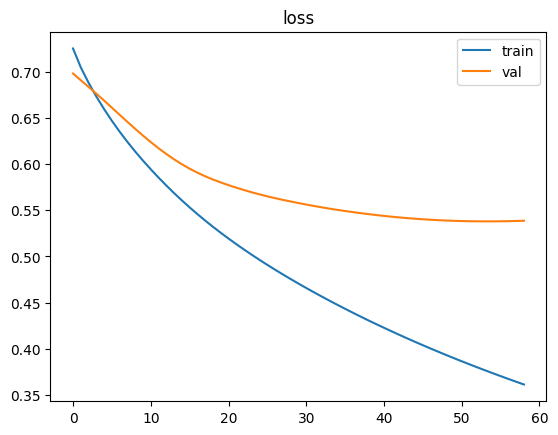

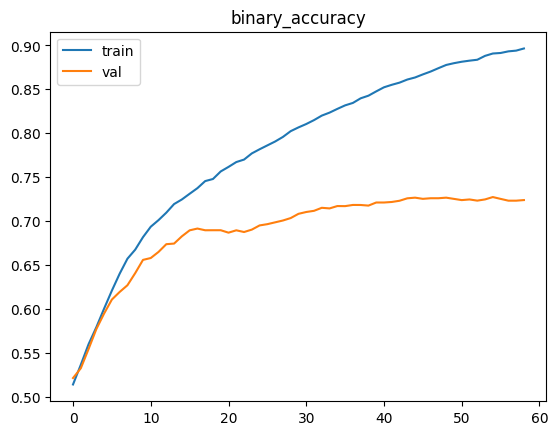

In [105]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [106]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.40747076814824884
train_binary_accuracy: 0.8481643416664817
loss: 0.5613878423517401
binary_accuracy: 0.7195616906339471


In [107]:
model.save('../models/tinynet.pt')

In [108]:
other_model = TinyNet(204, 8, 301, 10, 8)
other_model.load('../models/tinynet.pt')
optimizer = Adam
loss = BCEWithLogitsLoss()
metric = TF.classification.binary_accuracy
other_model.compile(optimizer, loss, metric)

In [112]:
train_result = other_model.evaluate(train)
result = other_model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.40464753996242175
train_binary_accuracy: 0.8494099649516019
loss: 0.5638000585816123
binary_accuracy: 0.7142857150598005


In [113]:
from deepmeg.training.callbacks import L2Reg

In [117]:
other_model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(
            monitor='loss_val',
            restore_best_weights=False
        ),
        L2Reg(
            [
                'unmixing_layer.weight',
                'fc_layer.weight',
                'fc_layer.bias'
            ],
            [
                .01,
                .01,
                .0001
            ]
        )
    ]
)

Epoch 0   loss_train:  0.4646   |    binary_accuracy_train:  0.8412   |    loss_val:  0.4459   |    binary_accuracy_val:  0.8727
Epoch 1   loss_train:  0.4549   |    binary_accuracy_train:  0.8493   |    loss_val:  0.4485   |    binary_accuracy_val:  0.8576
Epoch 2   loss_train:  0.4486   |    binary_accuracy_train:  0.8583   |    loss_val:  0.4505   |    binary_accuracy_val:  0.8487
Epoch 3   loss_train:  0.4431   |    binary_accuracy_train:  0.8625   |    loss_val:  0.4523   |    binary_accuracy_val:  0.8418
Epoch 4   loss_train:  0.4382   |    binary_accuracy_train:  0.8661   |    loss_val:  0.4541   |    binary_accuracy_val:  0.8425
Epoch 5   loss_train:  0.4337   |    binary_accuracy_train:  0.8690   |    loss_val:  0.4561   |    binary_accuracy_val:  0.8377
The training loop was completed at epoch 7 due to an interruption
  4%|▍         | 6/150 [00:03<01:34,  1.53it/s]


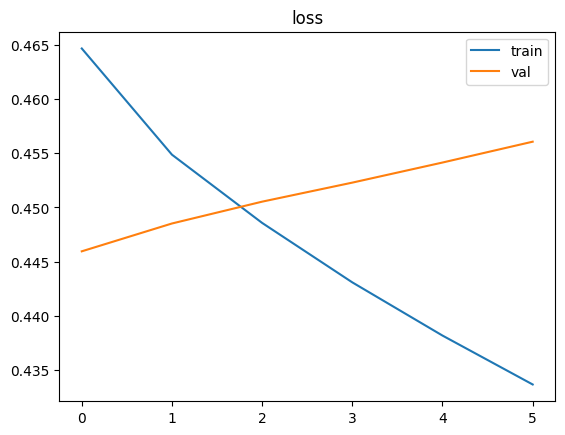

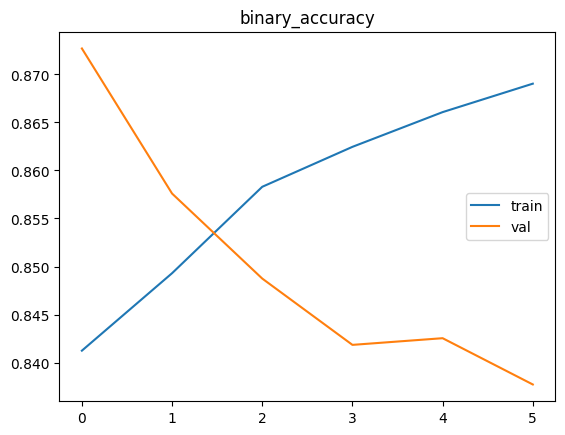

In [118]:
history = other_model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [119]:
train_result = other_model.evaluate(train)
result = other_model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.4370158748193221
train_binary_accuracy: 0.8645104928450151
loss: 0.6275018561970104
binary_accuracy: 0.7041395956819708
